# 🤖 06_Model_Evaluation — Перевірка фінальної моделі (Hold-out Test)
# Project: Прогнозування Відтоку Клієнтів
# Team Lead: Vitalii Subbotin
# Date: 2025-10-15
# ---
# Мета: перевірити якість фінальної моделі LightGBM на відкладеній тестовій вибірці

In [1]:
# 1. Імпорт бібліотек
import os
import joblib
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, RocCurveDisplay, ConfusionMatrixDisplay
)

sns.set(style="whitegrid")

In [2]:
# 2. Шляхи
BASE_DIR = Path("..")
DATA_PATH = BASE_DIR / "data" / "df1_mean.csv"
MODELS_DIR = BASE_DIR / "models"
MODEL_PATH = MODELS_DIR / "best_model_lgb.pkl"

print("DATA_PATH ->", DATA_PATH)
print("MODEL_PATH ->", MODEL_PATH)

DATA_PATH -> ..\data\df1_mean.csv
MODEL_PATH -> ..\models\best_model_lgb.pkl


In [3]:
# 3. Завантаження даних
df = pd.read_csv(DATA_PATH)

if 'id' in df.columns:
    df.drop(columns=['id'], inplace=True)
if 'Churn' in df.columns and 'churn' not in df.columns:
    df.rename(columns={'Churn': 'churn'}, inplace=True)

X = df.drop(columns=['churn'])
y = df['churn']

# 🔹 Спочатку поділяємо дані
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)
print("Train shape:", X_train.shape, "Test shape:", X_test.shape)

Train shape: (57514, 10) Test shape: (14379, 10)


In [4]:
# 4. Масштабування тільки на train (✅ без leakage)
binary_cols = [c for c in X.columns if X[c].nunique() <= 2]
num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
cols_to_scale = [c for c in num_cols if c not in binary_cols]

scaler = StandardScaler()
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()
X_train_scaled[cols_to_scale] = scaler.fit_transform(X_train[cols_to_scale])
X_test_scaled[cols_to_scale] = scaler.transform(X_test[cols_to_scale])

# Збереження нового scaler (оновлена версія)
joblib.dump(scaler, MODELS_DIR / "scaler_clean.pkl")
print("✅ Scaler (clean, без leakage) збережено у:", MODELS_DIR / "scaler_clean.pkl")

✅ Scaler (clean, без leakage) збережено у: ..\models\scaler_clean.pkl


In [5]:
# 5. Завантаження найкращої моделі
model = joblib.load(MODEL_PATH)
print("✅ Модель LightGBM завантажена успішно.")

✅ Модель LightGBM завантажена успішно.


In [7]:
# 6. Прогнозування та обчислення метрик
import os
os.environ["LOKY_MAX_CPU_COUNT"] = "8" 

y_pred = model.predict(X_test_scaled)
y_proba = model.predict_proba(X_test_scaled)[:, 1]

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc = roc_auc_score(y_test, y_proba)

print("\n📊 Результати (чиста оцінка без leakage):")
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1-score:  {f1:.4f}")
print(f"ROC-AUC:   {roc:.4f}")


📊 Результати (чиста оцінка без leakage):
Accuracy:  0.9514
Precision: 0.9664
Recall:    0.9456
F1-score:  0.9559
ROC-AUC:   0.9920


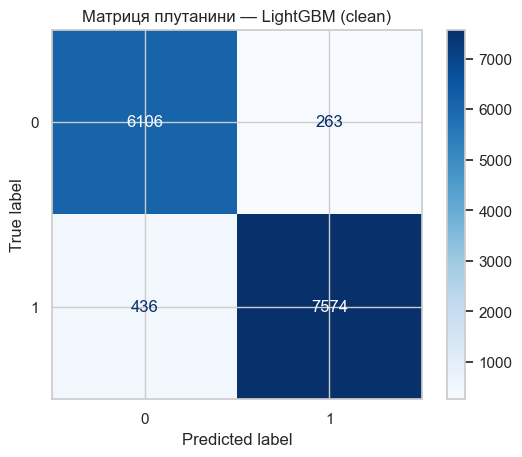

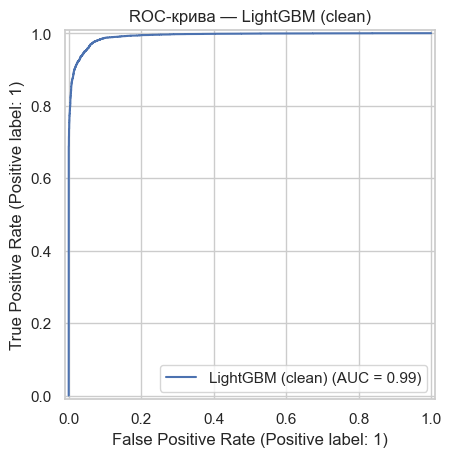

In [8]:
# 7. Візуалізація
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap="Blues")
plt.title("Матриця плутанини — LightGBM (clean)")
plt.show()

RocCurveDisplay.from_predictions(y_test, y_proba, name="LightGBM (clean)")
plt.title("ROC-крива — LightGBM (clean)")
plt.show()

In [9]:
# 8. Збереження результатів
results = pd.DataFrame([{
    "model": "LightGBM_clean",
    "accuracy": acc,
    "precision": prec,
    "recall": rec,
    "f1": f1,
    "roc_auc": roc
}])

results_path = MODELS_DIR / "final_evaluation_clean.csv"
results.to_csv(results_path, index=False)
print(f"\n✅ Результати (clean) збережено у: {results_path}")


✅ Результати (clean) збережено у: ..\models\final_evaluation_clean.csv
